NAME:PAREENITA A.SHIRSATH B.E.A.I.&.D.S. ROLL.NO:49

AIFBA EXPERIMENT NO : 03

--- Sample of Generated Employee Data ---
   Employee_ID          Role Company_Type  Years_Experience  Salary  \
0         1001  Data Analyst      Startup               5.6   94744   
1         1002  Data Analyst      Finance              14.3  192569   
2         1003  Data Analyst      Finance              11.0  167235   
3         1004  Data Analyst      Startup               9.0  121123   
4         1005  Data Analyst      Startup               2.3  106708   

   Performance_Score  
0                  4  
1                  5  
2                  3  
3                  1  
4                  1  

Calculating Elbow Method...


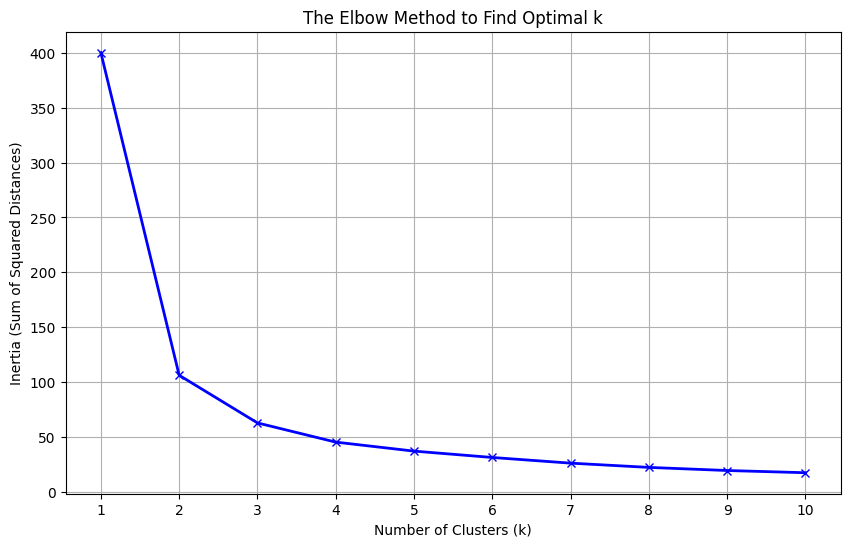

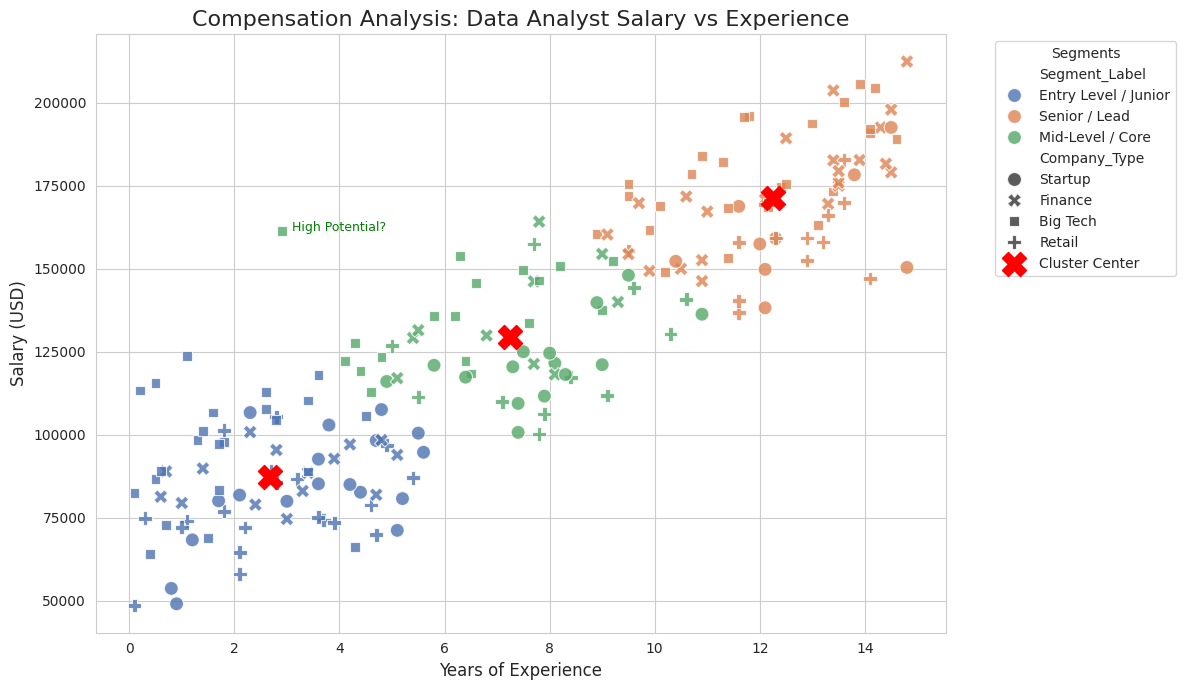


--- Market Segment Analysis ---
                      Years_Experience    Salary
Segment_Label                                   
Entry Level / Junior               2.7   87206.1
Mid-Level / Core                   7.2  129444.0
Senior / Lead                     12.3  171366.4

--- Anomaly Detection (Underpaid Seniors) ---
Found 0 potentially underpaid senior employees.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. Synthetic Data Generation (Mimicking Real World)
# ==========================================
np.random.seed(42)
n_employees = 200

# Generate random experience (0 to 15 years)
experience = np.random.uniform(0, 15, n_employees)

# Base salary calculation + random variation
# Logic: Base $60k + $8k per year of experience + Random noise
salary = 60000 + (experience * 8000) + np.random.normal(0, 15000, n_employees)

# Add "Company Type" factor
company_types = np.random.choice(['Big Tech', 'Finance', 'Startup', 'Retail'], n_employees)
company_bonus = np.array([20000 if c == 'Big Tech' else
                          15000 if c == 'Finance' else
                          -5000 if c == 'Retail' else 0
                          for c in company_types])

salary = salary + company_bonus

# Ensure no negative salaries and round to nearest thousand
salary = np.maximum(salary, 45000).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'Employee_ID': range(1001, 1001 + n_employees),
    'Role': 'Data Analyst',
    'Company_Type': company_types,
    'Years_Experience': np.round(experience, 1),
    'Salary': salary,
    'Performance_Score': np.random.randint(1, 6, n_employees) # 1 to 5 rating
})

print("--- Sample of Generated Employee Data ---")
print(df.head())

# ==========================================
# 2. Preprocessing
# ==========================================
# We only cluster on 'Salary' and 'Years_Experience' to find market bands.
X = df[['Years_Experience', 'Salary']]

# Scale data (Crucial because Salary (100k) >>> Experience (5))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================================
# 3. The Elbow Method (Find Optimal k)
# ==========================================
# This calculates inertia for k=1 to k=10 to visualize the "Elbow"
inertia = []
K_range = range(1, 11)

print("\nCalculating Elbow Method...")

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    inertia.append(kmeans_test.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='x', linewidth=2, color='blue')
plt.title('The Elbow Method to Find Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(K_range)
plt.grid(True)
plt.show()
# NOTE: The script will pause here until you close the plot window.

# ==========================================
# 4. K-Means Clustering (Applying Optimal k)
# ==========================================
# Based on the Elbow plot, we see the bend at k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Rename clusters for readability (Automated naming based on avg salary)
cluster_map = {}
stats = df.groupby('Cluster')['Salary'].mean().sort_values()
labels = ['Entry Level / Junior', 'Mid-Level / Core', 'Senior / Lead']

for i, (cluster_id, _) in enumerate(stats.items()):
    cluster_map[cluster_id] = labels[i]

df['Segment_Label'] = df['Cluster'].map(cluster_map)

# ==========================================
# 5. Visualization (Final Results)
# ==========================================
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Main Scatter Plot
sns.scatterplot(
    data=df,
    x='Years_Experience',
    y='Salary',
    hue='Segment_Label',
    style='Company_Type', # Different shapes for different company types
    palette='deep',
    s=100,
    alpha=0.8
)

# Plot Centroids (The "Average" of each group)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, marker='X', label='Cluster Center')

# Formatting
plt.title('Compensation Analysis: Data Analyst Salary vs Experience', fontsize=16)
plt.xlabel('Years of Experience', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Segments")
plt.tight_layout()

# Label "Outliers" (High Pay, Low Exp)
high_potentials = df[(df['Salary'] > 130000) & (df['Years_Experience'] < 5)]
for _, row in high_potentials.iterrows():
    plt.text(row['Years_Experience']+0.2, row['Salary'], f"High Potential?", fontsize=9, color='green')

plt.show()

# ==========================================
# 6. Insight Report
# ==========================================
print("\n--- Market Segment Analysis ---")
summary = df.groupby('Segment_Label')[['Years_Experience', 'Salary']].mean().round(1)
print(summary)

print("\n--- Anomaly Detection (Underpaid Seniors) ---")
# Logic: Experience > 8 years but Salary < 100k
underpaid = df[(df['Years_Experience'] > 8) & (df['Salary'] < 100000)]
print(f"Found {len(underpaid)} potentially underpaid senior employees.")
if not underpaid.empty:
    print(underpaid[['Employee_ID', 'Company_Type', 'Years_Experience', 'Salary']].head())